In [1]:
import glob
import os
import json
from datetime import timedelta
import dask.bag
from dask.distributed import Client
from kerchunk.netCDF3 import NetCDF3ToZarr
from kerchunk.combine import MultiZarrToZarr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
from numba import float32, float64, guvectorize
import numpy as np
import xarray as xr
import uxarray as uxr
xr.set_options(keep_attrs=True)
%matplotlib inline

In [2]:
# CAM output files
FILES = {
    'control': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.control.01/atm/hist/*.h0.*.nc"))
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.control.06/atm/hist/*.h0.*.nc")),
    'SAI2020': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.01/atm/hist/*.h0.*.nc"))[0:300] # 2020-2044
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02/atm/hist/*.h0.*.nc"))[:-12] # 2045-2099
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02_ext02/atm/hist/*.h0.*.nc")), # 2100-2130
    'SAI2080': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.09/atm/hist/*.h0.*.nc"))
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01/atm/hist/*.h0.*.nc"))
}

# WACCM output files
WACFILES = {
    'SAI2020': ['/home/jasperdj/simone/GLENS/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0.SWCF.201901-206812.nc',
        '/home/jasperdj/simone/GLENS/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0.SWCF.206901-210012.nc']
        + ['/home/jasperdj/simone/GLENS/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0.LWCF.201901-206812.nc',
        '/home/jasperdj/simone/GLENS/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0.LWCF.206901-210012.nc']
}

In [3]:
def open_mfdataset(filepaths: list[str], ncstore_dir: str='~/kerchunk', **kwargs):
    """a faster alternative to xr.open_mfdataset using kerchunk
    
    This function uses kerchunk to create an NC_STORE reference file,
    that instructs the program how to read the netCDF files efficiently. 
    Coordinates must be consistent throughout all files.
    The NC_STORE is saved after first use, and will be read on each 
    subsequent usage of this function.
    
    Parameters:
    filepaths : str or list[str]
        (list of) netCDF file names, may contain wild cards
    ncstore_dir: Pathlike
        Path where NC_STORE reference files will be saved
    kwargs: dict
        any additional keyword arguments are passed on to xr.open_dataset
        
    Returns: xr.Dataset
        a Dataset instance containing all the netCDF data
        
    v0.0
    """
    
    # make sorted list of absolute filepaths
    if isinstance(filepaths, str):
        filepaths = glob.glob(filepaths)
    filepaths = sorted([os.path.abspath(fp) for fp in filepaths])
    if len(filepaths) == 1: # use xr.open_dataset directly if there is one file
        return xr.open_dataset(filepaths[0], **kwargs)
    
    # set default keyword arguments for xr.open_dataset on NC_STORE file
    default_kw = {'engine':'kerchunk', 'storage_options':{'target_protocol':'file'}}
    for (k,v) in default_kw.items():
        if k in kwargs:
            print(f'open_mfdataset(): ignoring keyword {k}')
        kwargs[k] = v
    
    # create NC_STORE filename from netCDF filename, including timestamp
    # of first and last file. Open and return dataset if the file already exists
    ncstore_dir = os.path.expanduser(ncstore_dir)
    timestr = lambda i: os.path.basename(filepaths[i]).split('.')[-2] # timestamp
    ncstorefile = (os.path.basename(filepaths[0])
                   .replace(timestr(0),f"{timestr(0)}_{timestr(-1)}")
                   .replace('.nc','.json'))
    ncstore_path = os.path.join(ncstore_dir, ncstorefile)
    if not os.path.exists(ncstore_dir):
        os.mkdir(ncstore_dir)
    elif os.path.exists(ncstore_path):
        print(f"Reading combined kerchunk reference file {ncstore_path}")
        return xr.open_dataset(ncstore_path, **kwargs)
    
    # make new NC_STORE data
    filebag = dask.bag.from_sequence(filepaths, npartitions=None)
    reffiles = (filebag.map(NetCDF3ToZarr, inline_threshold=0, max_chunk_size=0)
                .map(lambda z: z.translate()).compute())
    mzz = MultiZarrToZarr(reffiles, concat_dims=['time'], coo_map={'time':'cf:time'})
    
    # write NC_STORE data and return opened dataset
    with open(f"{ncstore_path}", "wb") as f:
       print(f"Writing combined kerchunk reference file {ncstore_path}")
       f.write(json.dumps(mzz.translate()).encode())
    
    return xr.open_dataset(ncstore_path, **kwargs)

In [4]:
# open CAM output files
cam = {k:open_mfdataset(v, chunks={'time':1}) for k,v in FILES.items()}
for exp in cam:
    cam[exp] = cam[exp].assign_coords({'time':('time',(cam[exp].time-timedelta(days=15,hours=12)).data,cam[exp].time.attrs)})

Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e21.BSSP585cmip6.f09_g17.control.01.cam.h0.2015-01_2130-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e21.BSSP585cmip6.f09_g17.2020feedback.01.cam.h0.2020-01_2130-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01.cam.h0.2100-01_2099-12.json


In [5]:
# open WACCM output files
waccm = {
    # 'control': xr.open_mfdataset(WACFILES['control'], compat='override'),
    'SAI2020': xr.open_mfdataset(WACFILES['SAI2020']),
}
waccm['SAI2020'] = waccm['SAI2020'].assign_coords({'time':('time',waccm['SAI2020'].time_bnds.mean('nbnd').data, waccm['SAI2020'].time.attrs)})

In [6]:
slice_i = slice('2020','2039')
slice_f = slice('2080','2099')

In [7]:
%%time
var = 'SWCF'
SWCF = {
    'cam_ref_ann': cam['control'][var].sel(time=slice_i).mean('time', keep_attrs=True),
    'cam_ref_JJA': cam['control'][var].sel(time=slice_i).groupby('time.season')['JJA'].mean('time', keep_attrs=True),
    'cam_ref_DJF': cam['control'][var].sel(time=slice_i).groupby('time.season')['DJF'].mean('time', keep_attrs=True),
    'cam_cnt_ann': cam['control'][var].sel(time=slice_f).mean('time', keep_attrs=True),
    'cam_cnt_JJA': cam['control'][var].sel(time=slice_f).groupby('time.season')['JJA'].mean('time', keep_attrs=True),
    'cam_cnt_DJF': cam['control'][var].sel(time=slice_f).groupby('time.season')['DJF'].mean('time', keep_attrs=True),
    'cam_sai_ann': cam['SAI2020'][var].sel(time=slice_f).mean('time', keep_attrs=True),
    'cam_sai_JJA': cam['SAI2020'][var].sel(time=slice_f).groupby('time.season')['JJA'].mean('time', keep_attrs=True),
    'cam_sai_DJF': cam['SAI2020'][var].sel(time=slice_f).groupby('time.season')['DJF'].mean('time', keep_attrs=True),
    'waccm_sai_ann': waccm['SAI2020'][var].sel(time=slice_f).mean('time', keep_attrs=True),
    'waccm_sai_JJA': waccm['SAI2020'][var].sel(time=slice_f).groupby('time.season')['JJA'].mean('time', keep_attrs=True),
    'waccm_sai_DJF': waccm['SAI2020'][var].sel(time=slice_f).groupby('time.season')['DJF'].mean('time', keep_attrs=True),
}
for label in SWCF:
    SWCF[label] = SWCF[label].compute()

CPU times: user 2.57 s, sys: 5.22 s, total: 7.79 s
Wall time: 2.79 s


In [8]:
%%time
var = 'LWCF'
LWCF = {
    'cam_ref_ann': cam['control'][var].sel(time=slice_i).mean('time', keep_attrs=True),
    'cam_ref_JJA': cam['control'][var].sel(time=slice_i).groupby('time.season')['JJA'].mean('time', keep_attrs=True),
    'cam_ref_DJF': cam['control'][var].sel(time=slice_i).groupby('time.season')['DJF'].mean('time', keep_attrs=True),
    'cam_cnt_ann': cam['control'][var].sel(time=slice_f).mean('time', keep_attrs=True),
    'cam_cnt_JJA': cam['control'][var].sel(time=slice_f).groupby('time.season')['JJA'].mean('time', keep_attrs=True),
    'cam_cnt_DJF': cam['control'][var].sel(time=slice_f).groupby('time.season')['DJF'].mean('time', keep_attrs=True),
    'cam_sai_ann': cam['SAI2020'][var].sel(time=slice_f).mean('time', keep_attrs=True),
    'cam_sai_JJA': cam['SAI2020'][var].sel(time=slice_f).groupby('time.season')['JJA'].mean('time', keep_attrs=True),
    'cam_sai_DJF': cam['SAI2020'][var].sel(time=slice_f).groupby('time.season')['DJF'].mean('time', keep_attrs=True),
    'waccm_sai_ann': waccm['SAI2020'][var].sel(time=slice_f).mean('time', keep_attrs=True),
    'waccm_sai_JJA': waccm['SAI2020'][var].sel(time=slice_f).groupby('time.season')['JJA'].mean('time', keep_attrs=True),
    'waccm_sai_DJF': waccm['SAI2020'][var].sel(time=slice_f).groupby('time.season')['DJF'].mean('time', keep_attrs=True),
}
for label in LWCF:
    LWCF[label] = LWCF[label].compute()

CPU times: user 2.51 s, sys: 6.17 s, total: 8.68 s
Wall time: 2.81 s


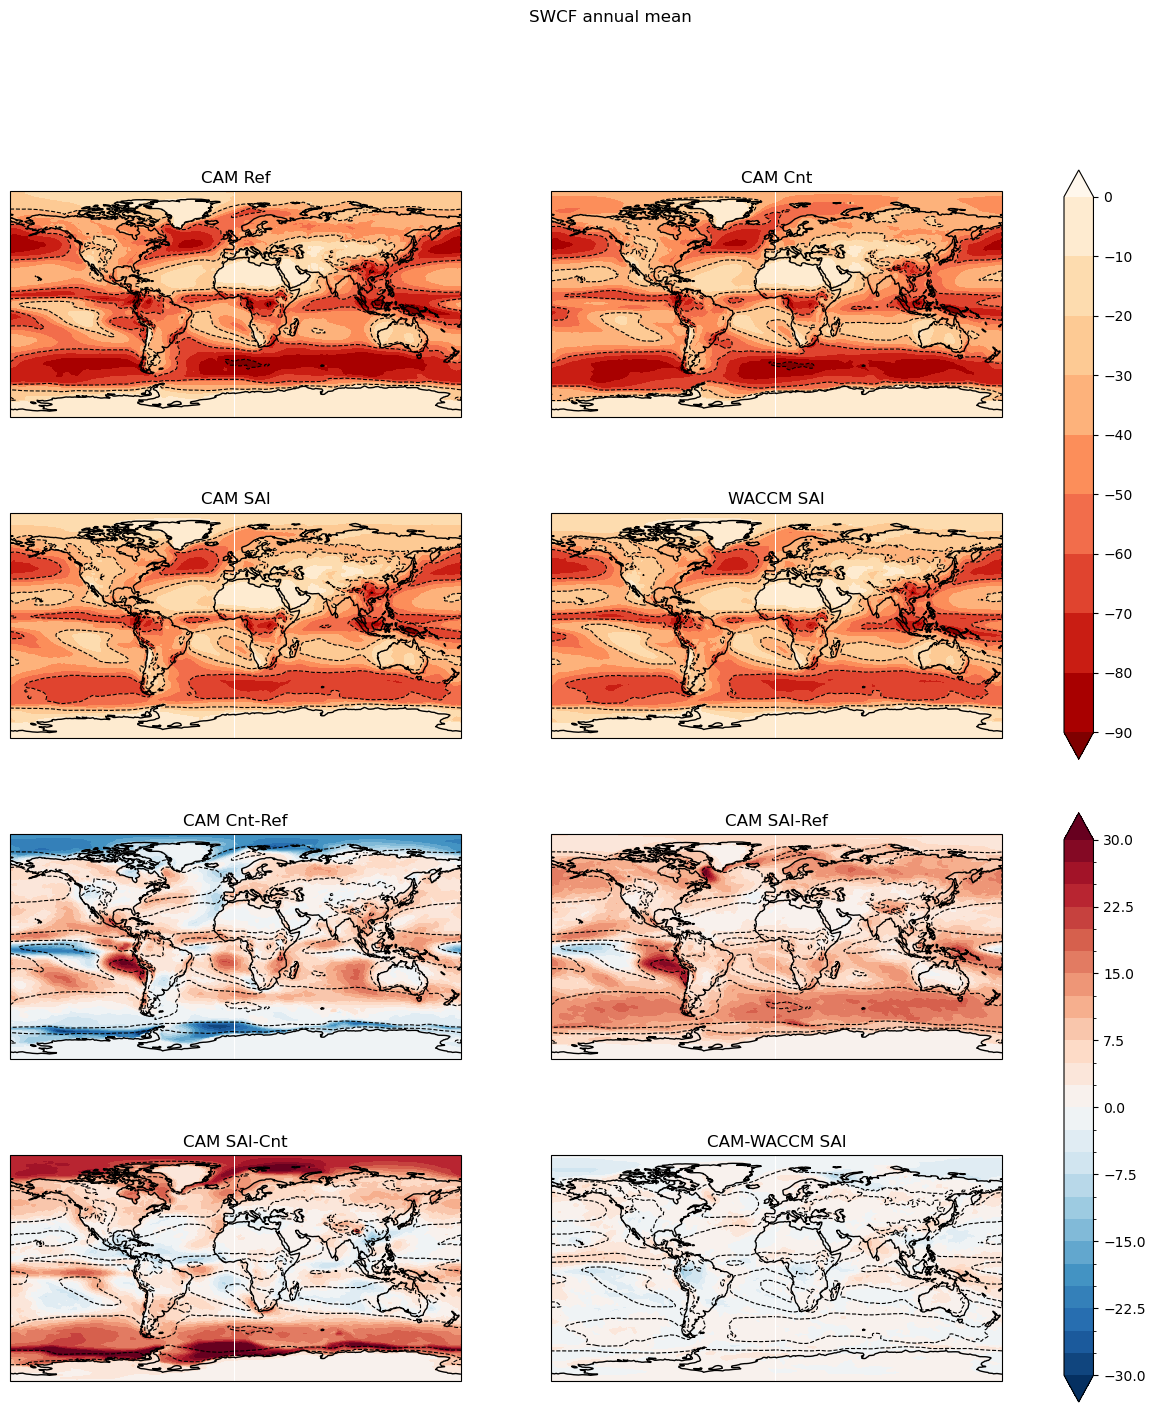

In [9]:
fig, axs = plt.subplots(4,2, figsize=(16,16), subplot_kw=dict(projection=ccrs.PlateCarree()))
axs = axs.flatten()
data = SWCF
season = 'ann'

kwargs = dict(levels=np.arange(0,-91,-10), extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, cmap='OrRd_r')
ckwargs = dict(levels=kwargs['levels'][::3], extend='both', transform=ccrs.PlateCarree(), colors='k', linewidths=0.8)
dkwargs = dict(levels=np.arange(-30,30.01,2.5), extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, cmap='RdBu_r')

p0 = data[f'cam_ref_{season}'].plot.contourf(ax=axs[0], **kwargs)
c0 = data[f'cam_ref_{season}'].plot.contour(ax=axs[0], **ckwargs)
axs[0].set_title('CAM Ref')
p1 = data[f'cam_cnt_{season}'].plot.contourf(ax=axs[1], **kwargs)
c1 = data[f'cam_cnt_{season}'].plot.contour(ax=axs[1], **ckwargs)
axs[1].set_title('CAM Cnt')
p2 = data[f'cam_sai_{season}'].plot.contourf(ax=axs[2], **kwargs)
c2 = data[f'cam_sai_{season}'].plot.contour(ax=axs[2], **ckwargs)
axs[2].set_title('CAM SAI')
p3 = data[f'waccm_sai_{season}'].plot.contourf(ax=axs[3], **kwargs)
c3 = data[f'waccm_sai_{season}'].plot.contour(ax=axs[3], **ckwargs)
axs[3].set_title('WACCM SAI')
p4 = (data[f'cam_cnt_{season}']-data[f'cam_ref_{season}']).plot.contourf(ax=axs[4], **dkwargs)
c4 = data[f'cam_ref_{season}'].plot.contour(ax=axs[4], **ckwargs)
axs[4].set_title('CAM Cnt-Ref')
p5 = (data[f'cam_sai_{season}']-data[f'cam_ref_{season}']).plot.contourf(ax=axs[5], **dkwargs)
c5 = data[f'cam_ref_{season}'].plot.contour(ax=axs[5], **ckwargs)
axs[5].set_title('CAM SAI-Ref')
p6 = (data[f'cam_sai_{season}']-data[f'cam_cnt_{season}']).plot.contourf(ax=axs[6], **dkwargs)
c6 = data[f'cam_cnt_{season}'].plot.contour(ax=axs[6], **ckwargs)
axs[6].set_title('CAM SAI-Cnt')
p7 = (data[f'cam_sai_{season}']-data[f'waccm_sai_{season}']).plot.contourf(ax=axs[7], **dkwargs)
c7 = data[f'waccm_sai_{season}'].plot.contour(ax=axs[7], **ckwargs)
axs[7].set_title('CAM-WACCM SAI')

fig.colorbar(p0, ax=axs[:4])
fig.colorbar(p4, ax=axs[4:])
fig.suptitle('SWCF annual mean')

for ax in axs:
    ax.coastlines()
    ax.grid()

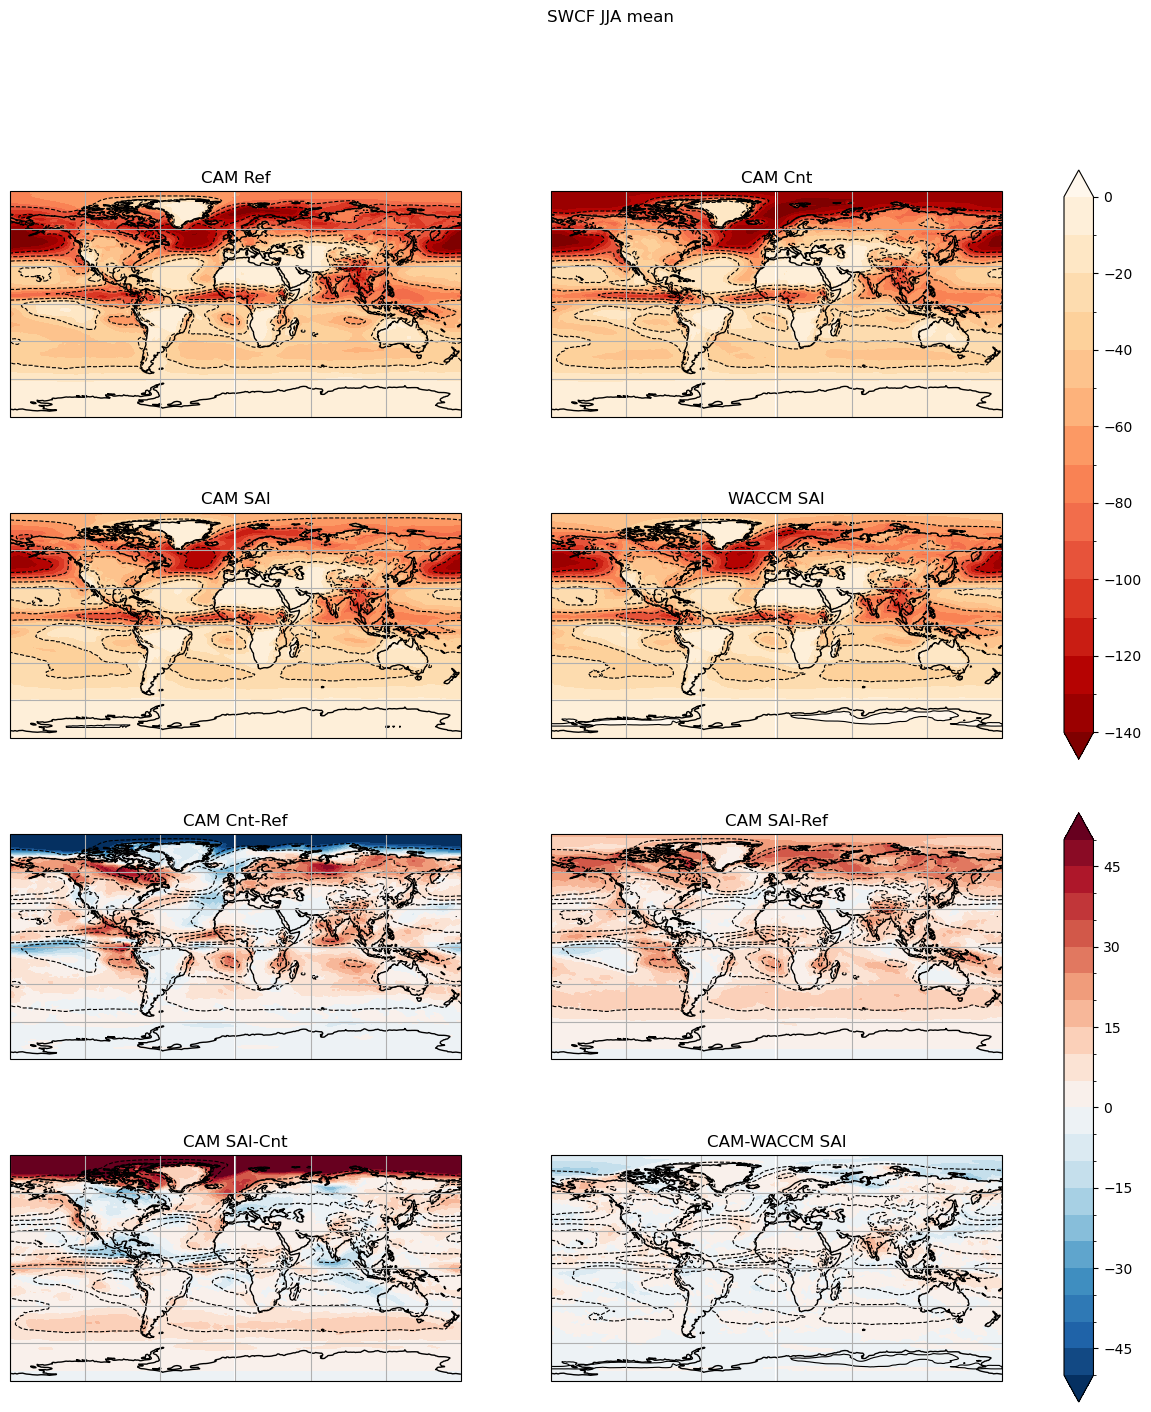

In [10]:
fig, axs = plt.subplots(4,2, figsize=(16,16), subplot_kw=dict(projection=ccrs.PlateCarree()))
axs = axs.flatten()
data = SWCF
season = 'JJA'

kwargs = dict(levels=np.arange(0,-141,-10), extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, cmap='OrRd_r')
ckwargs = dict(levels=kwargs['levels'][::3], extend='both', transform=ccrs.PlateCarree(), colors='k', linewidths=0.8)
dkwargs = dict(levels=np.arange(-50,50.01,5), extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, cmap='RdBu_r')

p0 = data[f'cam_ref_{season}'].plot.contourf(ax=axs[0], **kwargs)
c0 = data[f'cam_ref_{season}'].plot.contour(ax=axs[0], **ckwargs)
axs[0].set_title('CAM Ref')
p1 = data[f'cam_cnt_{season}'].plot.contourf(ax=axs[1], **kwargs)
c1 = data[f'cam_cnt_{season}'].plot.contour(ax=axs[1], **ckwargs)
axs[1].set_title('CAM Cnt')
p2 = data[f'cam_sai_{season}'].plot.contourf(ax=axs[2], **kwargs)
c2 = data[f'cam_sai_{season}'].plot.contour(ax=axs[2], **ckwargs)
axs[2].set_title('CAM SAI')
p3 = data[f'waccm_sai_{season}'].plot.contourf(ax=axs[3], **kwargs)
c3 = data[f'waccm_sai_{season}'].plot.contour(ax=axs[3], **ckwargs)
axs[3].set_title('WACCM SAI')
p4 = (data[f'cam_cnt_{season}']-data[f'cam_ref_{season}']).plot.contourf(ax=axs[4], **dkwargs)
c4 = data[f'cam_ref_{season}'].plot.contour(ax=axs[4], **ckwargs)
axs[4].set_title('CAM Cnt-Ref')
p5 = (data[f'cam_sai_{season}']-data[f'cam_ref_{season}']).plot.contourf(ax=axs[5], **dkwargs)
c5 = data[f'cam_ref_{season}'].plot.contour(ax=axs[5], **ckwargs)
axs[5].set_title('CAM SAI-Ref')
p6 = (data[f'cam_sai_{season}']-data[f'cam_cnt_{season}']).plot.contourf(ax=axs[6], **dkwargs)
c6 = data[f'cam_cnt_{season}'].plot.contour(ax=axs[6], **ckwargs)
axs[6].set_title('CAM SAI-Cnt')
p7 = (data[f'cam_sai_{season}']-data[f'waccm_sai_{season}']).plot.contourf(ax=axs[7], **dkwargs)
c7 = data[f'waccm_sai_{season}'].plot.contour(ax=axs[7], **ckwargs)
axs[7].set_title('CAM-WACCM SAI')

fig.colorbar(p0, ax=axs[:4])
fig.colorbar(p4, ax=axs[4:])
fig.suptitle('SWCF JJA mean')

for ax in axs:
    ax.coastlines()
    ax.gridlines()

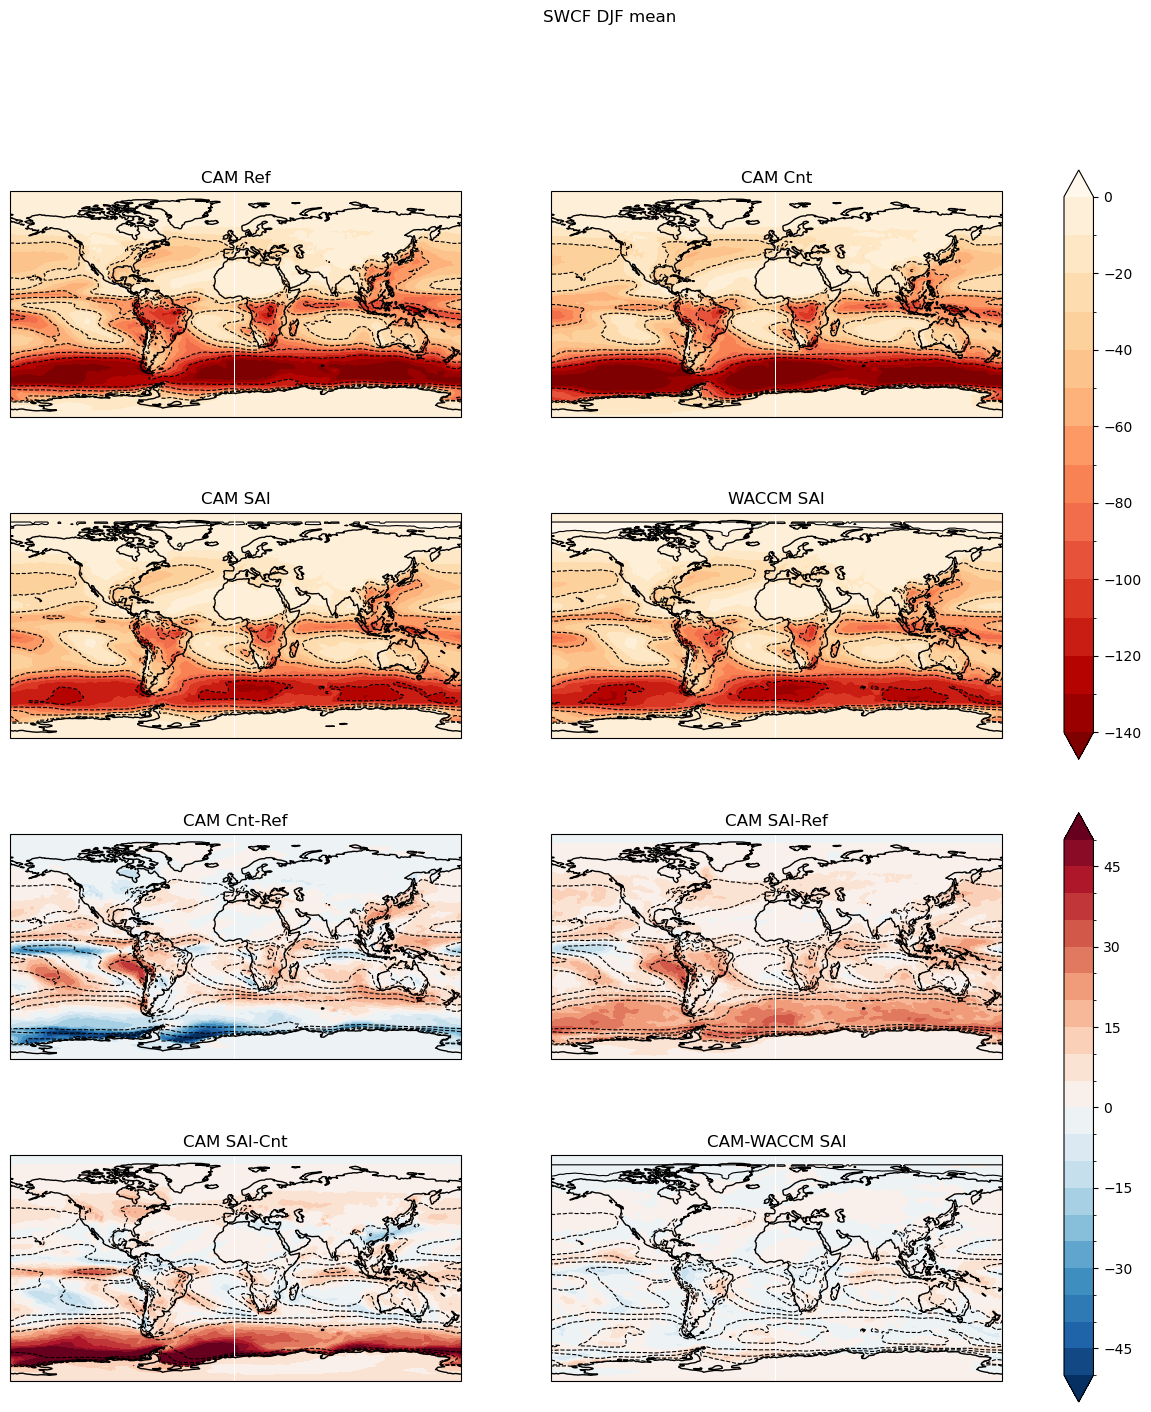

In [11]:
fig, axs = plt.subplots(4,2, figsize=(16,16), subplot_kw=dict(projection=ccrs.PlateCarree()))
axs = axs.flatten()
data = SWCF
season = 'DJF'

kwargs = dict(levels=np.arange(0,-141,-10), extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, cmap='OrRd_r')
ckwargs = dict(levels=kwargs['levels'][::3], extend='both', transform=ccrs.PlateCarree(), colors='k', linewidths=0.8)
dkwargs = dict(levels=np.arange(-50,50.01,5), extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, cmap='RdBu_r')

p0 = data[f'cam_ref_{season}'].plot.contourf(ax=axs[0], **kwargs)
c0 = data[f'cam_ref_{season}'].plot.contour(ax=axs[0], **ckwargs)
axs[0].set_title('CAM Ref')
p1 = data[f'cam_cnt_{season}'].plot.contourf(ax=axs[1], **kwargs)
c1 = data[f'cam_cnt_{season}'].plot.contour(ax=axs[1], **ckwargs)
axs[1].set_title('CAM Cnt')
p2 = data[f'cam_sai_{season}'].plot.contourf(ax=axs[2], **kwargs)
c2 = data[f'cam_sai_{season}'].plot.contour(ax=axs[2], **ckwargs)
axs[2].set_title('CAM SAI')
p3 = data[f'waccm_sai_{season}'].plot.contourf(ax=axs[3], **kwargs)
c3 = data[f'waccm_sai_{season}'].plot.contour(ax=axs[3], **ckwargs)
axs[3].set_title('WACCM SAI')
p4 = (data[f'cam_cnt_{season}']-data[f'cam_ref_{season}']).plot.contourf(ax=axs[4], **dkwargs)
c4 = data[f'cam_ref_{season}'].plot.contour(ax=axs[4], **ckwargs)
axs[4].set_title('CAM Cnt-Ref')
p5 = (data[f'cam_sai_{season}']-data[f'cam_ref_{season}']).plot.contourf(ax=axs[5], **dkwargs)
c5 = data[f'cam_ref_{season}'].plot.contour(ax=axs[5], **ckwargs)
axs[5].set_title('CAM SAI-Ref')
p6 = (data[f'cam_sai_{season}']-data[f'cam_cnt_{season}']).plot.contourf(ax=axs[6], **dkwargs)
c6 = data[f'cam_cnt_{season}'].plot.contour(ax=axs[6], **ckwargs)
axs[6].set_title('CAM SAI-Cnt')
p7 = (data[f'cam_sai_{season}']-data[f'waccm_sai_{season}']).plot.contourf(ax=axs[7], **dkwargs)
c7 = data[f'waccm_sai_{season}'].plot.contour(ax=axs[7], **ckwargs)
axs[7].set_title('CAM-WACCM SAI')

fig.colorbar(p0, ax=axs[:4])
fig.colorbar(p4, ax=axs[4:])
fig.suptitle('SWCF DJF mean')

for ax in axs:
    ax.coastlines()
    ax.grid()

Text(0.5, 0.98, 'SWCF CAM-WACCM SAI')

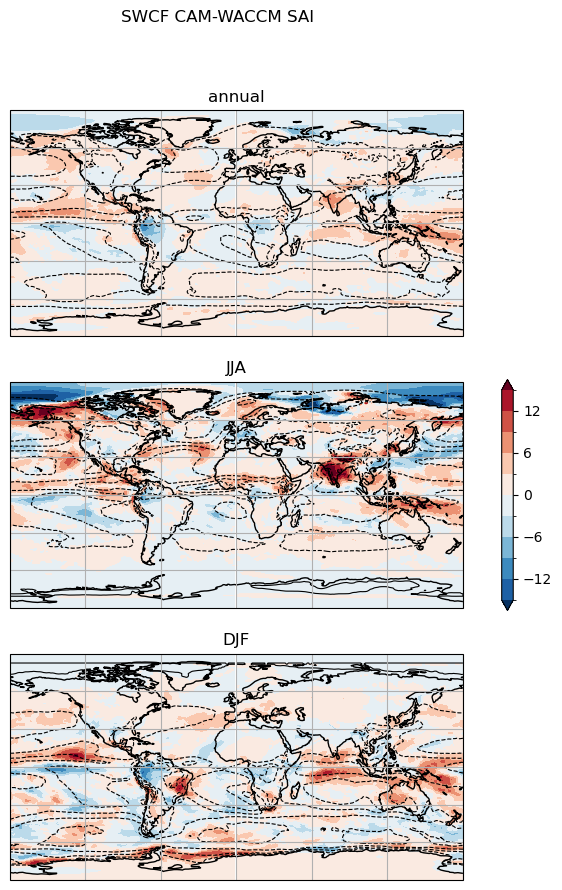

In [12]:
kwargs = dict(levels=np.arange(-15,16,3), extend='both', transform=ccrs.PlateCarree(), add_colorbar=False)
fig, axs = plt.subplots(3,1,figsize=(10,10), subplot_kw=dict(projection=ccrs.PlateCarree()))

p0 = (data['cam_sai_ann']-data['waccm_sai_ann']).plot.contourf(ax=axs[0], **kwargs)
c0 = data['waccm_sai_ann'].plot.contour(ax=axs[0], **ckwargs)
axs[0].set_title('annual')

p1 = (data['cam_sai_JJA']-data['waccm_sai_JJA']).plot.contourf(ax=axs[1], **kwargs)
c1 = data['waccm_sai_JJA'].plot.contour(ax=axs[1], **ckwargs)
axs[1].set_title('JJA')

p2 = (data['cam_sai_DJF']-data['waccm_sai_DJF']).plot.contourf(ax=axs[2], **kwargs)
c2 = data['waccm_sai_DJF'].plot.contour(ax=axs[2], **ckwargs)
axs[2].set_title('DJF')

for ax in axs.flatten():
    ax.coastlines()
    ax.gridlines()
    
fig.colorbar(p0, ax=axs, shrink=0.3)
fig.suptitle('SWCF CAM-WACCM SAI')

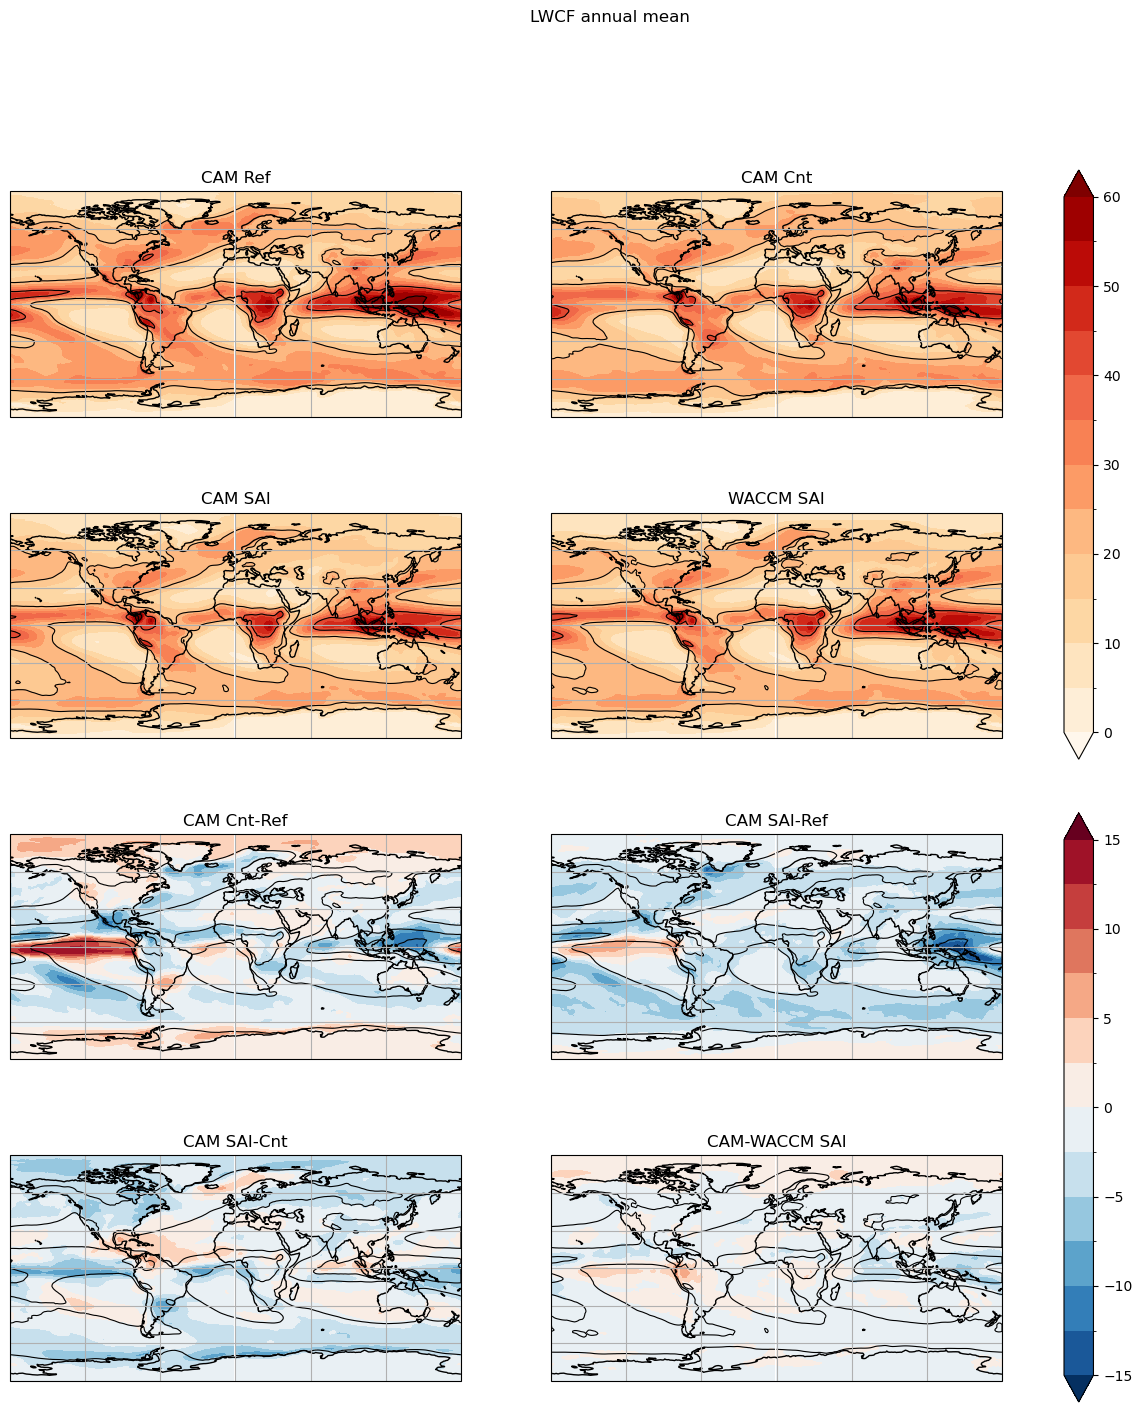

In [14]:
fig, axs = plt.subplots(4,2, figsize=(16,16), subplot_kw=dict(projection=ccrs.PlateCarree()))
axs = axs.flatten()
data = LWCF
season = 'ann'

kwargs = dict(levels=np.arange(0,61,5), extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, cmap='OrRd')
ckwargs = dict(levels=kwargs['levels'][::4], extend='both', transform=ccrs.PlateCarree(), colors='k', linewidths=0.8)
dkwargs = dict(levels=np.arange(-15,15.01,2.5), extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, cmap='RdBu_r')

p0 = data[f'cam_ref_{season}'].plot.contourf(ax=axs[0], **kwargs)
c0 = data[f'cam_ref_{season}'].plot.contour(ax=axs[0], **ckwargs)
axs[0].set_title('CAM Ref')
p1 = data[f'cam_cnt_{season}'].plot.contourf(ax=axs[1], **kwargs)
c1 = data[f'cam_cnt_{season}'].plot.contour(ax=axs[1], **ckwargs)
axs[1].set_title('CAM Cnt')
p2 = data[f'cam_sai_{season}'].plot.contourf(ax=axs[2], **kwargs)
c2 = data[f'cam_sai_{season}'].plot.contour(ax=axs[2], **ckwargs)
axs[2].set_title('CAM SAI')
p3 = data[f'waccm_sai_{season}'].plot.contourf(ax=axs[3], **kwargs)
c3 = data[f'waccm_sai_{season}'].plot.contour(ax=axs[3], **ckwargs)
axs[3].set_title('WACCM SAI')
p4 = (data[f'cam_cnt_{season}']-data[f'cam_ref_{season}']).plot.contourf(ax=axs[4], **dkwargs)
c4 = data[f'cam_ref_{season}'].plot.contour(ax=axs[4], **ckwargs)
axs[4].set_title('CAM Cnt-Ref')
p5 = (data[f'cam_sai_{season}']-data[f'cam_ref_{season}']).plot.contourf(ax=axs[5], **dkwargs)
c5 = data[f'cam_ref_{season}'].plot.contour(ax=axs[5], **ckwargs)
axs[5].set_title('CAM SAI-Ref')
p6 = (data[f'cam_sai_{season}']-data[f'cam_cnt_{season}']).plot.contourf(ax=axs[6], **dkwargs)
c6 = data[f'cam_cnt_{season}'].plot.contour(ax=axs[6], **ckwargs)
axs[6].set_title('CAM SAI-Cnt')
p7 = (data[f'cam_sai_{season}']-data[f'waccm_sai_{season}']).plot.contourf(ax=axs[7], **dkwargs)
c7 = data[f'waccm_sai_{season}'].plot.contour(ax=axs[7], **ckwargs)
axs[7].set_title('CAM-WACCM SAI')

fig.colorbar(p0, ax=axs[:4])
fig.colorbar(p4, ax=axs[4:])
fig.suptitle('LWCF annual mean')

for ax in axs:
    ax.coastlines()
    ax.gridlines()

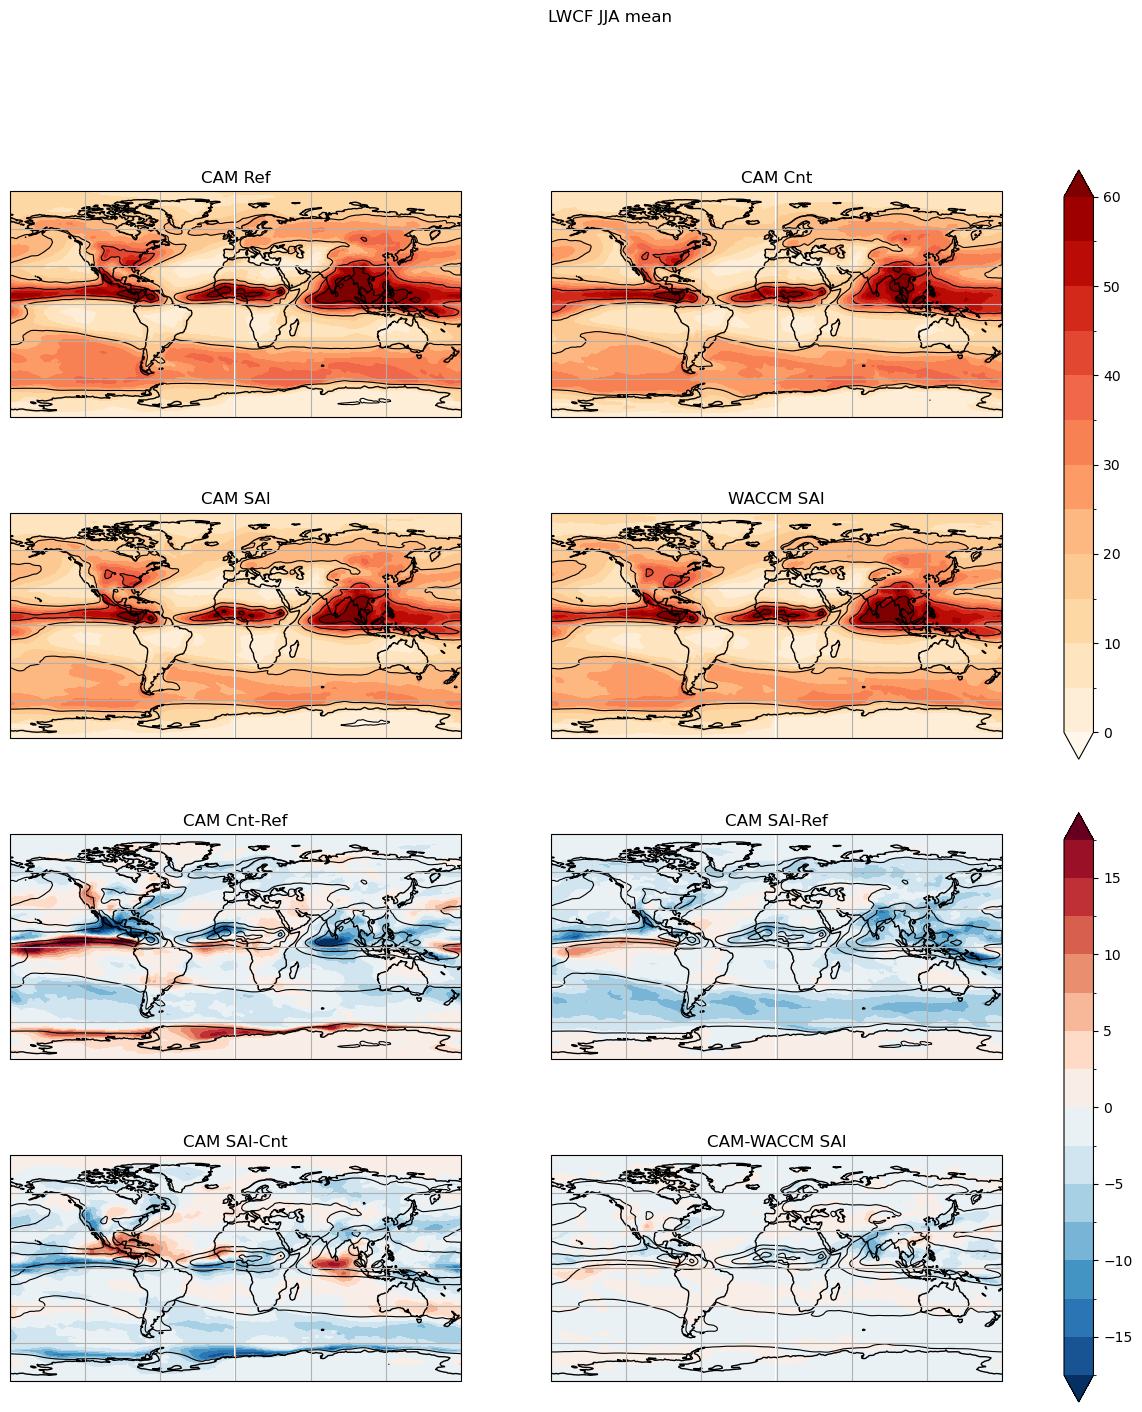

In [16]:
fig, axs = plt.subplots(4,2, figsize=(16,16), subplot_kw=dict(projection=ccrs.PlateCarree()))
axs = axs.flatten()
data = LWCF
season = 'JJA'

kwargs = dict(levels=np.arange(0,61,5), extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, cmap='OrRd')
ckwargs = dict(levels=kwargs['levels'][::4], extend='both', transform=ccrs.PlateCarree(), colors='k', linewidths=0.8)
dkwargs = dict(levels=np.arange(-17.5,17.51,2.5), extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, cmap='RdBu_r')

p0 = data[f'cam_ref_{season}'].plot.contourf(ax=axs[0], **kwargs)
c0 = data[f'cam_ref_{season}'].plot.contour(ax=axs[0], **ckwargs)
axs[0].set_title('CAM Ref')
p1 = data[f'cam_cnt_{season}'].plot.contourf(ax=axs[1], **kwargs)
c1 = data[f'cam_cnt_{season}'].plot.contour(ax=axs[1], **ckwargs)
axs[1].set_title('CAM Cnt')
p2 = data[f'cam_sai_{season}'].plot.contourf(ax=axs[2], **kwargs)
c2 = data[f'cam_sai_{season}'].plot.contour(ax=axs[2], **ckwargs)
axs[2].set_title('CAM SAI')
p3 = data[f'waccm_sai_{season}'].plot.contourf(ax=axs[3], **kwargs)
c3 = data[f'waccm_sai_{season}'].plot.contour(ax=axs[3], **ckwargs)
axs[3].set_title('WACCM SAI')
p4 = (data[f'cam_cnt_{season}']-data[f'cam_ref_{season}']).plot.contourf(ax=axs[4], **dkwargs)
c4 = data[f'cam_ref_{season}'].plot.contour(ax=axs[4], **ckwargs)
axs[4].set_title('CAM Cnt-Ref')
p5 = (data[f'cam_sai_{season}']-data[f'cam_ref_{season}']).plot.contourf(ax=axs[5], **dkwargs)
c5 = data[f'cam_ref_{season}'].plot.contour(ax=axs[5], **ckwargs)
axs[5].set_title('CAM SAI-Ref')
p6 = (data[f'cam_sai_{season}']-data[f'cam_cnt_{season}']).plot.contourf(ax=axs[6], **dkwargs)
c6 = data[f'cam_cnt_{season}'].plot.contour(ax=axs[6], **ckwargs)
axs[6].set_title('CAM SAI-Cnt')
p7 = (data[f'cam_sai_{season}']-data[f'waccm_sai_{season}']).plot.contourf(ax=axs[7], **dkwargs)
c7 = data[f'waccm_sai_{season}'].plot.contour(ax=axs[7], **ckwargs)
axs[7].set_title('CAM-WACCM SAI')

fig.colorbar(p0, ax=axs[:4])
fig.colorbar(p4, ax=axs[4:])
fig.suptitle('LWCF JJA mean')

for ax in axs:
    ax.coastlines()
    ax.gridlines()

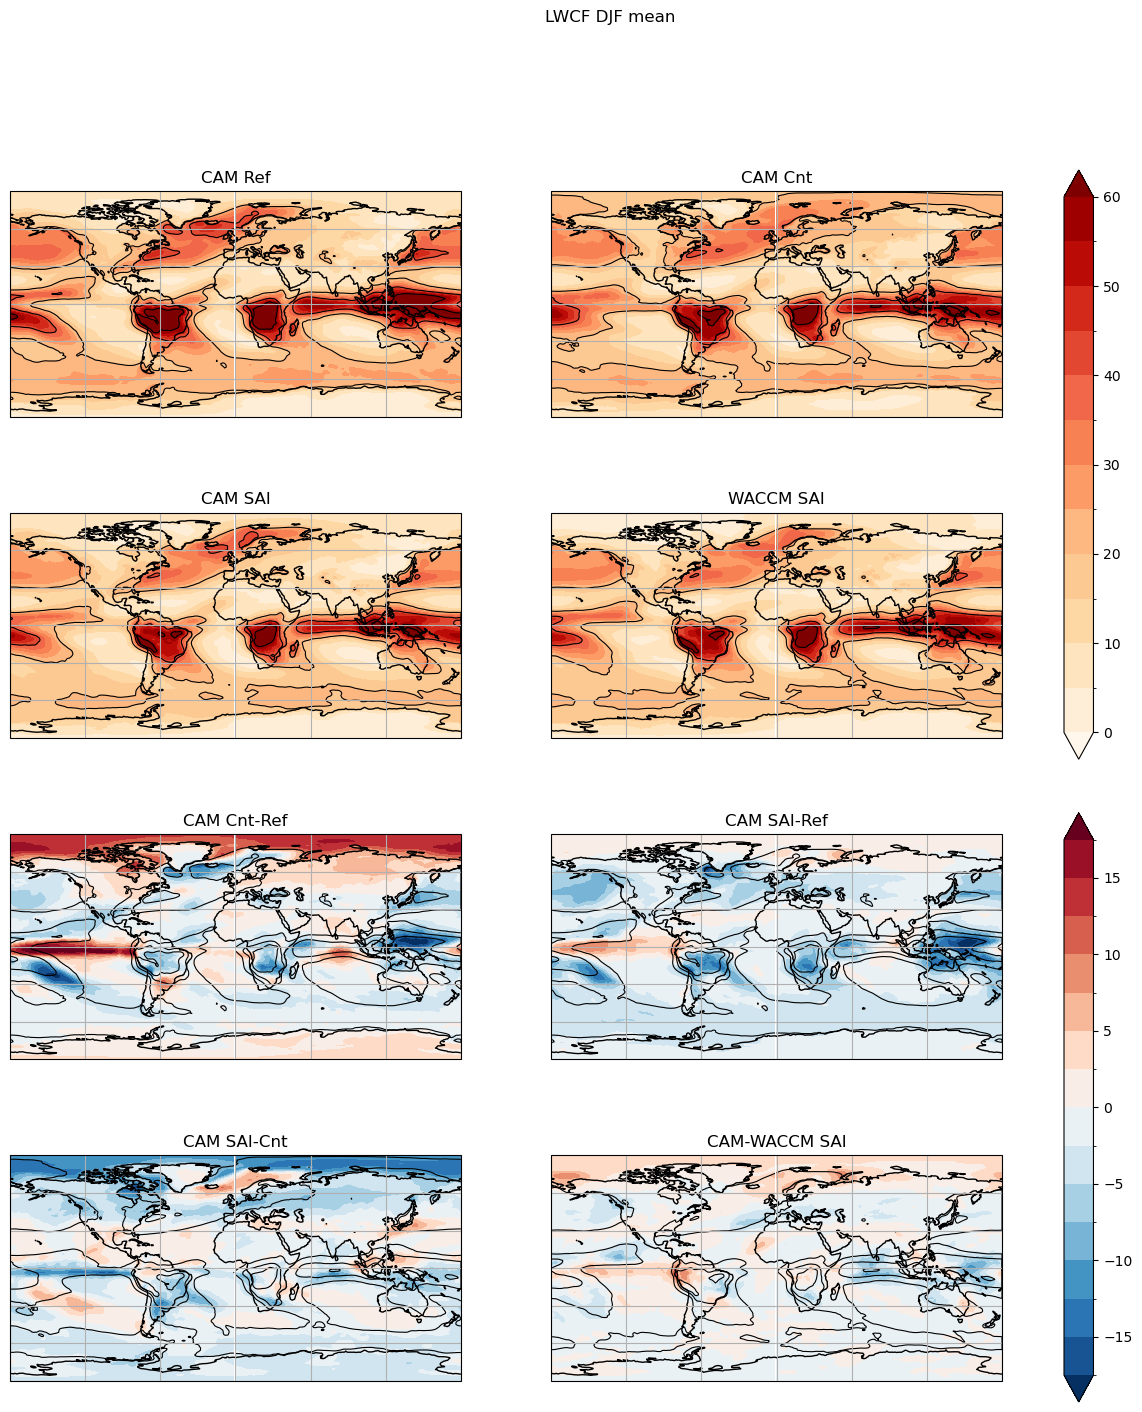

In [17]:
fig, axs = plt.subplots(4,2, figsize=(16,16), subplot_kw=dict(projection=ccrs.PlateCarree()))
axs = axs.flatten()
data = LWCF
season = 'DJF'

kwargs = dict(levels=np.arange(0,61,5), extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, cmap='OrRd')
ckwargs = dict(levels=kwargs['levels'][::4], extend='both', transform=ccrs.PlateCarree(), colors='k', linewidths=0.8)
dkwargs = dict(levels=np.arange(-17.5,17.51,2.5), extend='both', transform=ccrs.PlateCarree(), add_colorbar=False, cmap='RdBu_r')

p0 = data[f'cam_ref_{season}'].plot.contourf(ax=axs[0], **kwargs)
c0 = data[f'cam_ref_{season}'].plot.contour(ax=axs[0], **ckwargs)
axs[0].set_title('CAM Ref')
p1 = data[f'cam_cnt_{season}'].plot.contourf(ax=axs[1], **kwargs)
c1 = data[f'cam_cnt_{season}'].plot.contour(ax=axs[1], **ckwargs)
axs[1].set_title('CAM Cnt')
p2 = data[f'cam_sai_{season}'].plot.contourf(ax=axs[2], **kwargs)
c2 = data[f'cam_sai_{season}'].plot.contour(ax=axs[2], **ckwargs)
axs[2].set_title('CAM SAI')
p3 = data[f'waccm_sai_{season}'].plot.contourf(ax=axs[3], **kwargs)
c3 = data[f'waccm_sai_{season}'].plot.contour(ax=axs[3], **ckwargs)
axs[3].set_title('WACCM SAI')
p4 = (data[f'cam_cnt_{season}']-data[f'cam_ref_{season}']).plot.contourf(ax=axs[4], **dkwargs)
c4 = data[f'cam_ref_{season}'].plot.contour(ax=axs[4], **ckwargs)
axs[4].set_title('CAM Cnt-Ref')
p5 = (data[f'cam_sai_{season}']-data[f'cam_ref_{season}']).plot.contourf(ax=axs[5], **dkwargs)
c5 = data[f'cam_ref_{season}'].plot.contour(ax=axs[5], **ckwargs)
axs[5].set_title('CAM SAI-Ref')
p6 = (data[f'cam_sai_{season}']-data[f'cam_cnt_{season}']).plot.contourf(ax=axs[6], **dkwargs)
c6 = data[f'cam_cnt_{season}'].plot.contour(ax=axs[6], **ckwargs)
axs[6].set_title('CAM SAI-Cnt')
p7 = (data[f'cam_sai_{season}']-data[f'waccm_sai_{season}']).plot.contourf(ax=axs[7], **dkwargs)
c7 = data[f'waccm_sai_{season}'].plot.contour(ax=axs[7], **ckwargs)
axs[7].set_title('CAM-WACCM SAI')

fig.colorbar(p0, ax=axs[:4])
fig.colorbar(p4, ax=axs[4:])
fig.suptitle('LWCF DJF mean')

for ax in axs:
    ax.coastlines()
    ax.gridlines()

Text(0.5, 0.98, 'LWCF CAM-WACCM SAI')

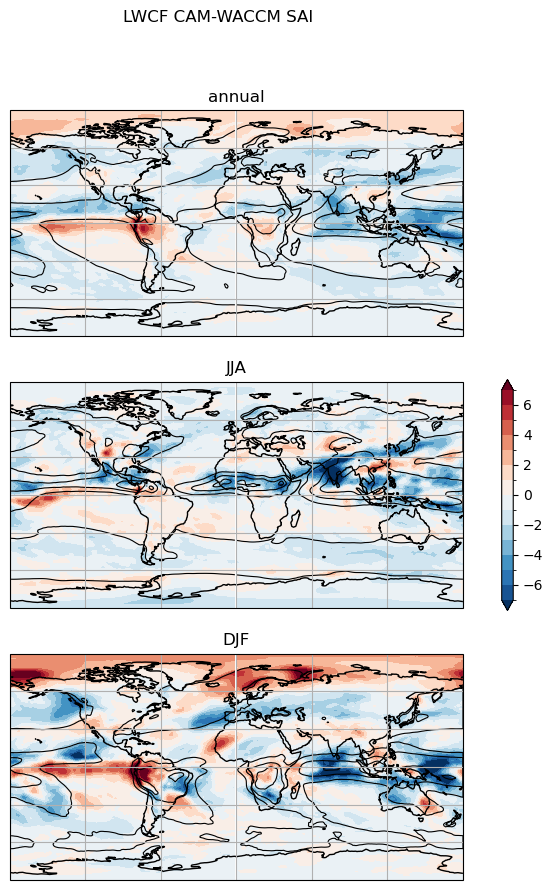

In [20]:
kwargs = dict(levels=np.arange(-7,8,1), extend='both', transform=ccrs.PlateCarree(), add_colorbar=False)
fig, axs = plt.subplots(3,1,figsize=(10,10), subplot_kw=dict(projection=ccrs.PlateCarree()))

p0 = (data['cam_sai_ann']-data['waccm_sai_ann']).plot.contourf(ax=axs[0], **kwargs)
c0 = data['waccm_sai_ann'].plot.contour(ax=axs[0], **ckwargs)
axs[0].set_title('annual')

p1 = (data['cam_sai_JJA']-data['waccm_sai_JJA']).plot.contourf(ax=axs[1], **kwargs)
c1 = data['waccm_sai_JJA'].plot.contour(ax=axs[1], **ckwargs)
axs[1].set_title('JJA')

p2 = (data['cam_sai_DJF']-data['waccm_sai_DJF']).plot.contourf(ax=axs[2], **kwargs)
c2 = data['waccm_sai_DJF'].plot.contour(ax=axs[2], **ckwargs)
axs[2].set_title('DJF')

for ax in axs.flatten():
    ax.coastlines()
    ax.gridlines()
    
fig.colorbar(p0, ax=axs, shrink=0.3)
fig.suptitle('LWCF CAM-WACCM SAI')